# Gene Expression Analysis: Differentially Expressed Genes by Sex and Brain Region
We implemented the exploration of differential gene expression in the brain in our data analysis. We introduced some initial genes that might be worth analyzing and the confidence levels for their corresponding tests.
This report is divided into the following sections, each with an explanation of the code and figures used:

- Data Exploration
- Normalization
- T-Test Analysis
- GLM Analysis
- Random Forest Analysis
- Conclusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import matplotlib as mpl
import pyreadr
from sklearn.decomposition import PCA
import scipy.stats as stats
import statsmodels.stats.multitest as multitest
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import copy


## 2.Standardization
Comparison between laboratories requires data standardization. We need to first standardize the data based on zscore and then perform t-test.

In [2]:
dataset= pyreadr.read_r('brain.rda')
expression = dataset["expression"]
genes = dataset["genes"]
samples = dataset["samples"]
nan_genes = genes[genes["chrom"].isna()].index.values # genes not associated with chromosomes
control_genes = [gene for gene in nan_genes if gene.startswith("AFFX")]
human_genes = [gene for gene in genes.index.values if gene not in control_genes]
precise_data  = pd.concat([expression,samples],axis= 1).dropna()

from scipy.stats import zscore

precise_data[control_genes] = precise_data[control_genes].apply(zscore, axis=0)
precise_data[human_genes] = precise_data[human_genes].apply(zscore, axis=0)

In [3]:
import numpy as np
import pandas as pd
import copy

def median_polish(data):

    global_median = np.median(data.values)
    

    row_effects = np.zeros(data.shape[0])
    col_effects = np.zeros(data.shape[1])
    
    while True:
        adjusted_data = data.values - global_median - col_effects
        row_medians = np.median(adjusted_data, axis=1)
        row_effects += row_medians
        adjusted_data -= row_medians[:, np.newaxis]

        adjusted_data = adjusted_data - row_effects[:, np.newaxis]
        col_medians = np.median(adjusted_data, axis=0)
        col_effects += col_medians
        adjusted_data -= col_medians

        new_global_median = np.median(adjusted_data)

        if np.allclose(global_median, new_global_median, atol=1e-6):
            break
        
        global_median = new_global_median
    
    estimated_data = adjusted_data + global_median + row_effects[:, np.newaxis] + col_effects
    return pd.DataFrame(estimated_data, index=data.index, columns=data.columns)



dataset= pyreadr.read_r('brain.rda')
expression = dataset["expression"]
genes = dataset["genes"]
samples = dataset["samples"]
nan_genes = genes[genes["chrom"].isna()].index.values # genes not associated with chromosomes
control_genes = [gene for gene in nan_genes if gene.startswith("AFFX")]
human_genes = [gene for gene in genes.index.values if gene not in control_genes]
precise_data  = pd.concat([expression,samples],axis= 1).dropna()
precise_data_polished = copy.copy(precise_data)
from scipy.stats import zscore



precise_data_polished[human_genes] = median_polish(precise_data[human_genes])
precise_data_polished[control_genes] = median_polish(precise_data[control_genes])

precise_data_polished[control_genes] = precise_data_polished[control_genes].apply(zscore, axis=0)
precise_data_polished[human_genes] = precise_data_polished[human_genes].apply(zscore, axis=0)

## Exploration of systematic differences
Our data analysis is based on the assumption that each laboratory's measurements are noisy representations of "true" gene expression, but there are systematic errors. One difference between seemingly "replicated" samples between laboratories is the version of the chip used. We first wanted to test whether there are systematic differences between different chip versions.


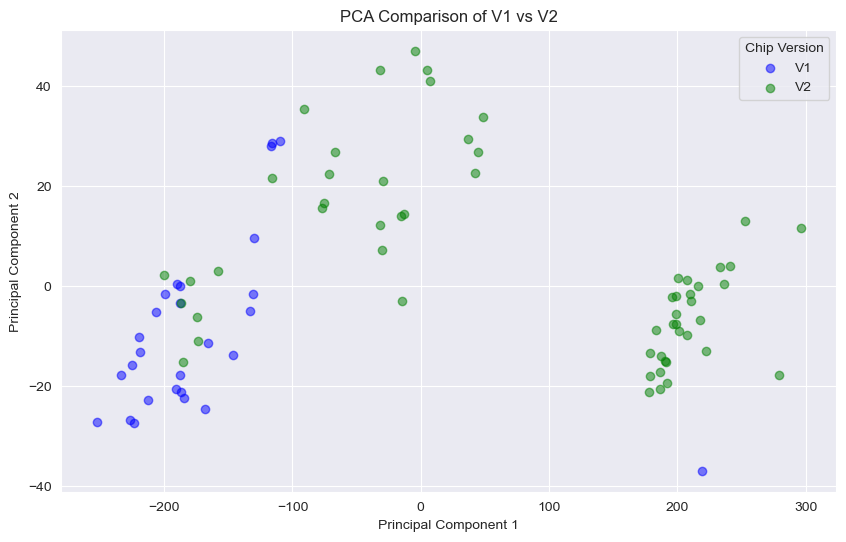

In [4]:
all_precise_data = precise_data[human_genes].values
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_precise_data)

plt.figure(figsize=(10, 6))

v1_idx = precise_data["chip.version"] == "v1"
plt.scatter(pca_result[v1_idx, 0], pca_result[v1_idx, 1], color='blue', label='V1', alpha=0.5)
v2_idx = precise_data["chip.version"] == "v2"
plt.scatter(pca_result[v2_idx, 0], pca_result[v2_idx, 1], color='green', label='V2', alpha=0.5)

plt.title("PCA Comparison of V1 vs V2")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")


plt.legend(title="Chip Version")
plt.grid(True)
plt.show()

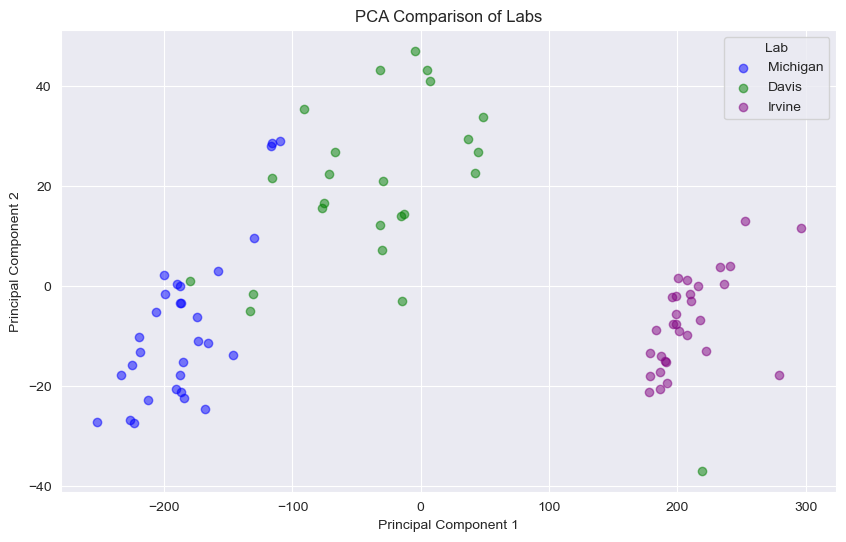

In [5]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_precise_data)

plt.figure(figsize=(10, 6))

m_idx = precise_data["lab"] == "Michigan"
plt.scatter(pca_result[m_idx, 0], pca_result[m_idx, 1], color='blue', label='Michigan', alpha=0.5)
d_idx = precise_data["lab"] == "Davis"
plt.scatter(pca_result[d_idx, 0], pca_result[d_idx, 1], color='green', label='Davis', alpha=0.5)
i_idx = precise_data["lab"] == "Irvine"
plt.scatter(pca_result[i_idx, 0], pca_result[i_idx, 1], color='purple', label='Irvine', alpha=0.5)

plt.title("PCA Comparison of Labs")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Add legend and show the plot
plt.legend(title="Lab")
plt.grid(True)
plt.show()

## 3. Batch Effect Correction

In [6]:
from pycombat import Combat

expression_data = expression.values
samples['lab'] = samples['lab'].astype(str)
samples['chip.version'] = samples['chip.version'].astype(str)
samples['combined_batch'] = samples['lab'] + "_" + samples['chip.version']
batch = samples['combined_batch']
combat = Combat()
mod = pd.get_dummies(samples[['sex','region']])
corrected_expression = combat.fit_transform(expression_data, samples['lab'], mod)

In [7]:
corrected_expression_df = pd.DataFrame(corrected_expression, index=expression.index, columns=expression.columns)
cor_expr_df = pd.concat([corrected_expression_df,samples],axis= 1).dropna()

#### Visualization for batch correction

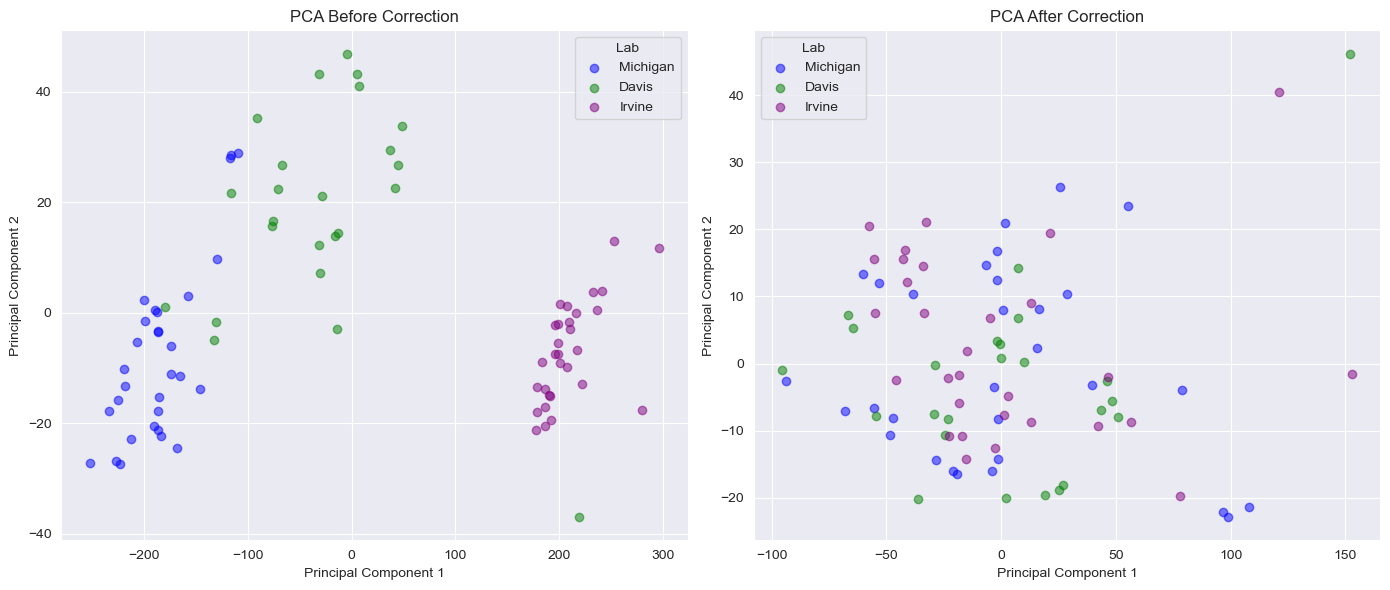

In [8]:
pca = PCA(n_components=2)
all_precise_data = precise_data[human_genes].values
pca_result_before = pca.fit_transform(all_precise_data)
pca_result_after = pca.fit_transform(corrected_expression)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
m_idx_before = precise_data["lab"] == "Michigan"
plt.scatter(pca_result_before[m_idx_before, 0], pca_result_before[m_idx_before, 1], color='blue', label='Michigan', alpha=0.5)
d_idx_before = precise_data["lab"] == "Davis"
plt.scatter(pca_result_before[d_idx_before, 0], pca_result_before[d_idx_before, 1], color='green', label='Davis', alpha=0.5)
i_idx_before = precise_data["lab"] == "Irvine"
plt.scatter(pca_result_before[i_idx_before, 0], pca_result_before[i_idx_before, 1], color='purple', label='Irvine', alpha=0.5)

plt.title("PCA Before Correction")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Lab")
plt.grid(True)

plt.subplot(1, 2, 2)
m_idx_after = precise_data["lab"] == "Michigan"
plt.scatter(pca_result_after[m_idx_after, 0], pca_result_after[m_idx_after, 1], color='blue', label='Michigan', alpha=0.5)
d_idx_after = precise_data["lab"] == "Davis"
plt.scatter(pca_result_after[d_idx_after, 0], pca_result_after[d_idx_after, 1], color='green', label='Davis', alpha=0.5)
i_idx_after = precise_data["lab"] == "Irvine"
plt.scatter(pca_result_after[i_idx_after, 0], pca_result_after[i_idx_after, 1], color='purple', label='Irvine', alpha=0.5)

plt.title("PCA After Correction")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Lab")
plt.grid(True)

plt.tight_layout()
plt.show()


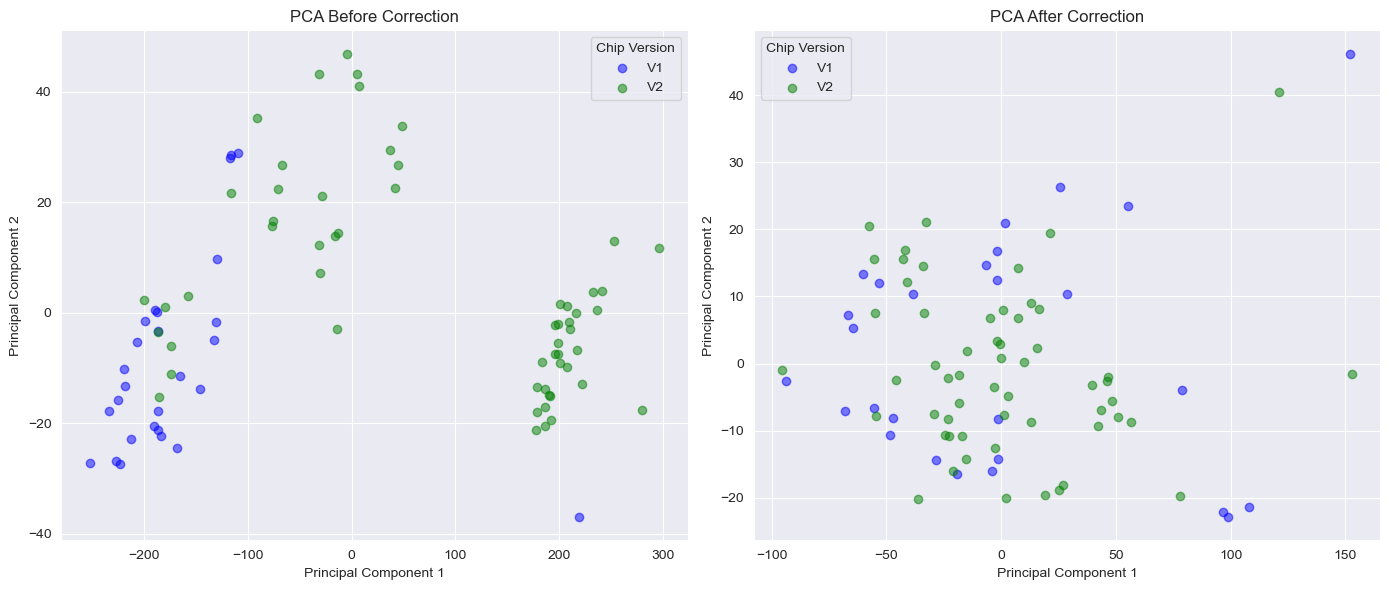

In [9]:
pca = PCA(n_components=2)
pca_result_before = pca.fit_transform(all_precise_data)

pca_result_after = pca.fit_transform(corrected_expression)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
v1_idx_before = precise_data["chip.version"] == "v1"
plt.scatter(pca_result_before[v1_idx_before, 0], pca_result_before[v1_idx_before, 1], color='blue', label='V1', alpha=0.5)

v2_idx_before = precise_data["chip.version"] == "v2"
plt.scatter(pca_result_before[v2_idx_before, 0], pca_result_before[v2_idx_before, 1], color='green', label='V2', alpha=0.5)

plt.title("PCA Before Correction")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Chip Version")
plt.grid(True)

plt.subplot(1, 2, 2)
v1_idx_after = precise_data["chip.version"] == "v1"
plt.scatter(pca_result_after[v1_idx_after, 0], pca_result_after[v1_idx_after, 1], color='blue', label='V1', alpha=0.5)

v2_idx_after = precise_data["chip.version"] == "v2"
plt.scatter(pca_result_after[v2_idx_after, 0], pca_result_after[v2_idx_after, 1], color='green', label='V2', alpha=0.5)

plt.title("PCA After Correction")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Chip Version")
plt.grid(True)

plt.tight_layout()
plt.show()

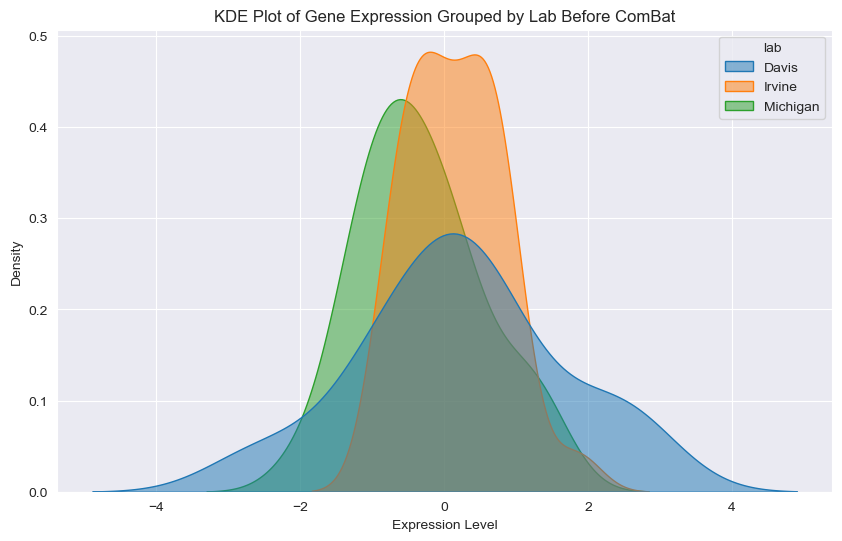

In [10]:
expression_data = precise_data_polished[human_genes]
samples_data = samples[['lab']]

# Combine expression data with metadata (e.g., lab information)
combined_data = pd.concat([expression_data, samples_data], axis=1)

# For visualization, choose a specific gene or average expression across multiple genes
# Here, we'll visualize the expression of the first gene (you can choose any gene)
gene = human_genes[10]  # or any specific gene you're interested in

# Create a KDE plot grouped by lab
plt.figure(figsize=(10, 6))
sns.kdeplot(data=combined_data, x=gene, hue='lab', fill=True, common_norm=False, alpha=0.5)

# Customize plot
plt.title('KDE Plot of Gene Expression Grouped by Lab Before ComBat')
plt.xlabel('Expression Level')
plt.ylabel('Density')
plt.show()


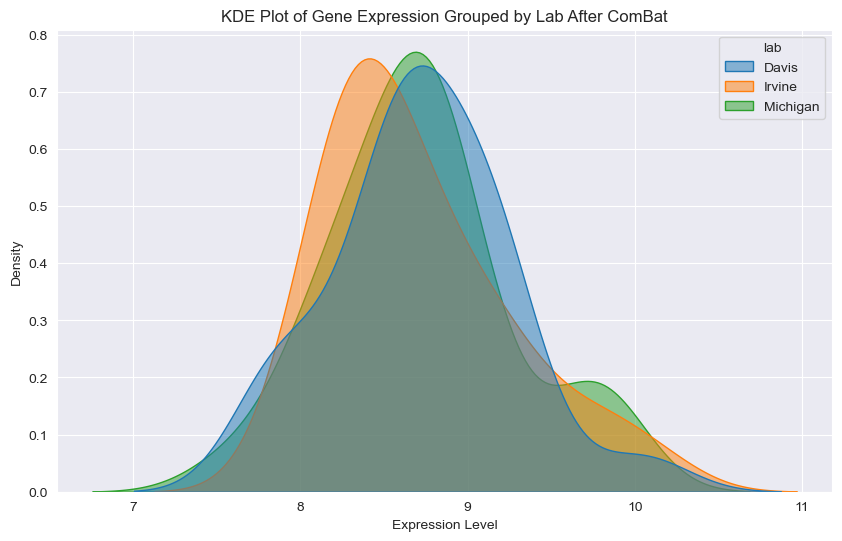

In [11]:
expression_data = cor_expr_df[human_genes]
samples_data = samples[['lab']]

combined_data = pd.concat([expression_data, samples_data], axis=1)
gene = human_genes[10]  

plt.figure(figsize=(10, 6))
sns.kdeplot(data=combined_data, x=gene, hue='lab', fill=True, common_norm=False, alpha=0.5)

plt.title('KDE Plot of Gene Expression Grouped by Lab After ComBat')
plt.xlabel('Expression Level')
plt.ylabel('Density')
plt.show()


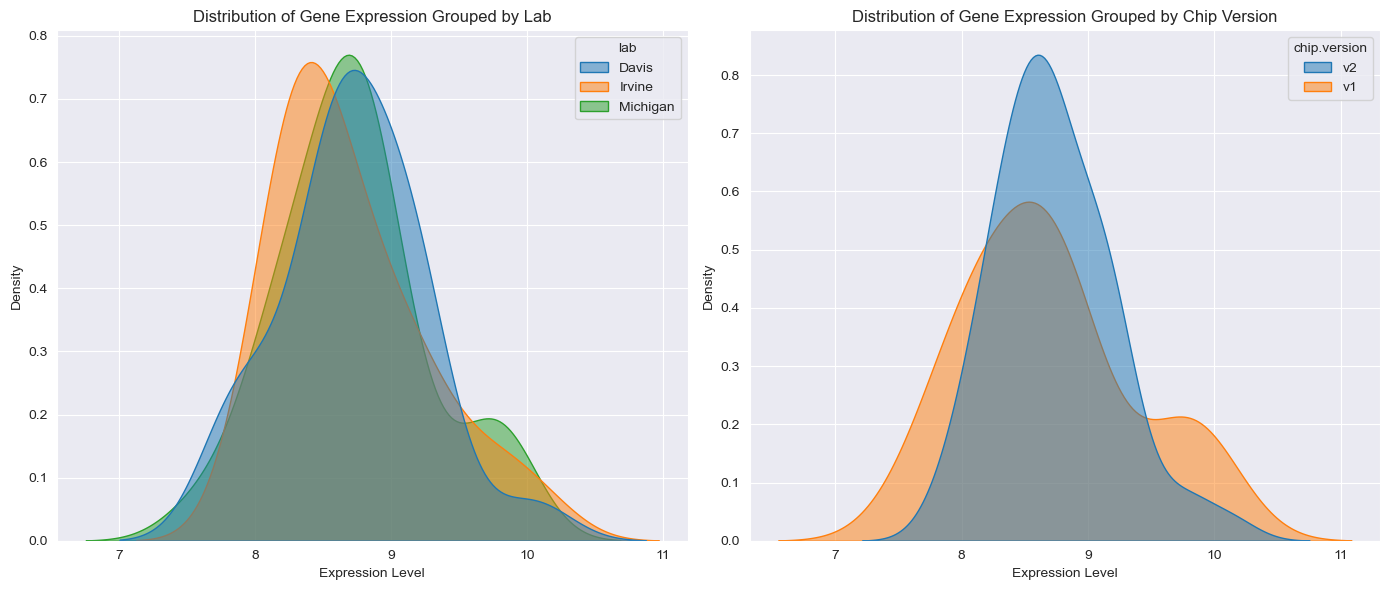

In [12]:
expression_data = cor_expr_df[human_genes]
samples_data = samples[['lab', 'chip.version']] 
combined_data = pd.concat([expression_data, samples_data], axis=1)

gene = human_genes[10] 

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(data=combined_data, x=gene, hue='lab', fill=True, common_norm=False, alpha=0.5)
plt.title('Distribution of Gene Expression Grouped by Lab')
plt.xlabel('Expression Level')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sns.kdeplot(data=combined_data, x=gene, hue='chip.version', fill=True, common_norm=False, alpha=0.5)
plt.title('Distribution of Gene Expression Grouped by Chip Version')
plt.xlabel('Expression Level')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Betch effect is corrected after the ComBat()

#### Y Chromosome genes expression visualization

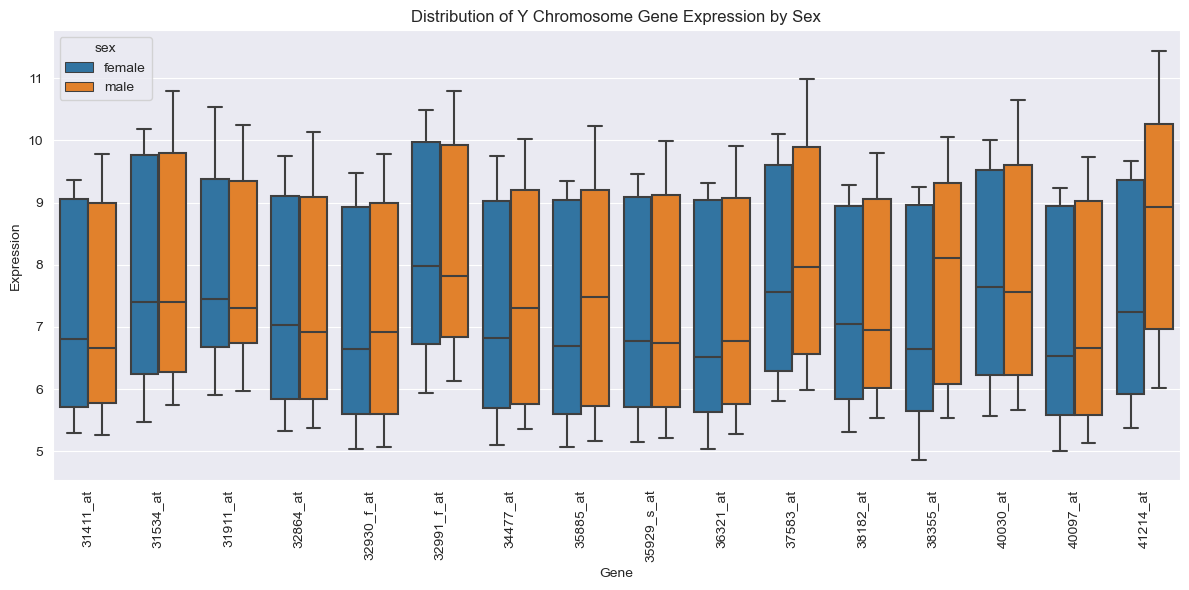

In [13]:
y_chromosome_genes = genes[genes["chrom"] == "Y"].index.values
y_expression = expression[y_chromosome_genes]
y_expression_data = pd.concat([y_expression, samples['sex']], axis=1).dropna()
melted_data = y_expression_data.melt(id_vars='sex', var_name='Gene', value_name='Expression')
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_data, x='Gene', y='Expression', hue='sex')
plt.title('Distribution of Y Chromosome Gene Expression by Sex')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 4.T-test Analysis
We currently have standardized data from which we can analyze the differences in *probe expression* between sexes and brain regions, but in order to remove systematic errors in the experimental design, such as chip effects, and analyze the differences in gene expression between subjects, we need to implement Tukey's median polishing algorithm.

### PartA T-tests [sex]
We performed both combined and individual tests on the polished data. Individual tests helped us see if genes were replicated across labs. Analyses were performed using simple independent t-tests with a significance level of 0.05.

In [14]:
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.multitest as multitest

def analyze_sex_differences(data):
    significant_genes = {}
    
    male_patients = data[data['sex'] == 'male']
    female_patients = data[data['sex'] == 'female']
    
    for probe in male_patients[human_genes]: 
        male_data = male_patients[probe].dropna()
        female_data = female_patients[probe].dropna()
        
        if len(male_data) > 1 and len(female_data) > 1: 
            t_stat, p_value = stats.ttest_ind(male_data, female_data, equal_var=False)
            significant_genes[probe] = p_value
    
    p_values = list(significant_genes.values())
    adjusted_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]
    
    for i, probe in enumerate(significant_genes.keys()):
        if adjusted_p_values[i] < 0.05:  
            print(f"Significant gene: {probe}, Adjusted p-value: {adjusted_p_values[i]}")
    
            if probe in genes.index:
                gene_symbol = genes.loc[probe, 'sym']
                chrom = genes.loc[probe, 'chrom']
                print(f"The gene symbol for {probe}: {gene_symbol}, chromosome: {chrom}.")
            else:
                print(f"{probe} not found in the gene data.")

    chrom_distribution = {}
    for i, probe in enumerate(significant_genes.keys()):
        if adjusted_p_values[i] < 0.05: 
            chrom = genes.loc[probe]["chrom"]  
            if chrom not in chrom_distribution:
                chrom_distribution[chrom] = 0
            chrom_distribution[chrom] += 1
    
    print("Chromosome distribution of significant genes:", chrom_distribution)


In [15]:
analyze_sex_differences(cor_expr_df)

Significant gene: 38355_at, Adjusted p-value: 2.4196025530313624e-09
The gene symbol for 38355_at: DDX3Y, chromosome: Y.
Significant gene: 41214_at, Adjusted p-value: 2.373916631839712e-13
The gene symbol for 41214_at: RPS4Y1, chromosome: Y.
Chromosome distribution of significant genes: {'Y': 2}


In [16]:
def analyze_sex_differences_bylab(data):
    significant_genes_overall = {}

    labs = data['lab'].unique()
    
    for lab in labs:
        print(f"Analyzing lab: {lab}")
        
        lab_data = data[data['lab'] == lab]
        male_patients = lab_data[lab_data['sex'] == 'male']
        female_patients = lab_data[lab_data['sex'] == 'female']
        
        significant_genes = {}
        
        for probe in male_patients[human_genes]: 
            male_data = male_patients[probe].dropna()
            female_data = female_patients[probe].dropna()
            
            if len(male_data) > 1 and len(female_data) > 1: 
                t_stat, p_value = stats.ttest_ind(male_data, female_data, equal_var=False)
                significant_genes[probe] = p_value
        
        p_values = list(significant_genes.values())
        adjusted_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]
        
        for i, probe in enumerate(significant_genes.keys()):
            if adjusted_p_values[i] < 0.05:  
                print(f"Significant gene: {probe}, Adjusted p-value: {adjusted_p_values[i]}")
                
                if probe in genes.index:
                    gene_symbol = genes.loc[probe, 'sym']
                    chrom = genes.loc[probe, 'chrom']
                    print(f"The gene symbol for {probe}: {gene_symbol}, chromosome: {chrom}.")
                else:
                    print(f"{probe} not found in the gene data.")
        
        chrom_distribution = {}
        for i, probe in enumerate(significant_genes.keys()):
            if adjusted_p_values[i] < 0.05:  
                chrom = genes.loc[probe]["chrom"]  
                if chrom not in chrom_distribution:
                    chrom_distribution[chrom] = 0
                chrom_distribution[chrom] += 1
        
        print("Chromosome distribution of significant genes:", chrom_distribution)
        print("=" * 50)  


#### Median Polished data

In [17]:
analyze_sex_differences_bylab(precise_data_polished)

Analyzing lab: Davis
Significant gene: 35885_at, Adjusted p-value: 0.0006907582742944859
The gene symbol for 35885_at: USP9Y, chromosome: Y.
Significant gene: 37583_at, Adjusted p-value: 7.183742666926949e-06
The gene symbol for 37583_at: KDM5D, chromosome: Y.
Significant gene: 38355_at, Adjusted p-value: 0.0028407713319902944
The gene symbol for 38355_at: DDX3Y, chromosome: Y.
Significant gene: 41214_at, Adjusted p-value: 2.7741971660558927e-08
The gene symbol for 41214_at: RPS4Y1, chromosome: Y.
Chromosome distribution of significant genes: {'Y': 4}
Analyzing lab: Irvine
Significant gene: 34477_at, Adjusted p-value: 6.744332698765844e-05
The gene symbol for 34477_at: UTY, chromosome: Y.
Significant gene: 35885_at, Adjusted p-value: 0.0013679298530753373
The gene symbol for 35885_at: USP9Y, chromosome: Y.
Significant gene: 37583_at, Adjusted p-value: 7.779533204390986e-08
The gene symbol for 37583_at: KDM5D, chromosome: Y.
Significant gene: 38355_at, Adjusted p-value: 7.77953320439098

#### Corrected Data

In [18]:
analyze_sex_differences_bylab(cor_expr_df)

Analyzing lab: Davis
Chromosome distribution of significant genes: {}
Analyzing lab: Irvine
Significant gene: 41214_at, Adjusted p-value: 0.0009872037164017989
The gene symbol for 41214_at: RPS4Y1, chromosome: Y.
Chromosome distribution of significant genes: {'Y': 1}
Analyzing lab: Michigan
Chromosome distribution of significant genes: {}


#### Significant Gene Analysis Results

| Lab        | Significant Gene | Adjusted P-value         | Gene Symbol | Chromosome |
|------------|------------------|--------------------------|-------------|------------|
| All        | 34477_at         | 0.00028324091116217515   | UTY         | Y          |
| All        | 35885_at         | 2.26106491150367e-07     | USP9Y       | Y          |
| All        | 37583_at         | 1.26690985389546e-15      | KDM5D       | Y          |
| All        | 38355_at         | 6.877219580778075e-08     | DDX3Y       | Y          |
| All        | 38446_at         | 1.1406967471560342e-07    | XIST        | X          |
| All        | 41214_at         | 1.749330200538374e-16      | RPS4Y1      | Y          |
| Davis      | 35885_at         | 0.0006907582742944859     | USP9Y       | Y          |
| Davis      | 37583_at         | 7.183742666926922e-06      | KDM5D       | Y          |
| Davis      | 38355_at         | 0.0028407713319902944     | DDX3Y       | Y          |
| Davis      | 41214_at         | 2.7741971660558927e-08     | RPS4Y1      | Y          |
| Irvine     | 34477_at         | 6.744332698765844e-05      | UTY         | Y          |
| Irvine     | 35885_at         | 0.0013679298530753373     | USP9Y       | Y          |
| Irvine     | 37583_at         | 7.779533204390985e-08      | KDM5D       | Y          |
| Irvine     | 38355_at         | 7.779533204390985e-08      | DDX3Y       | Y          |
| Irvine     | 38446_at         | 0.024919005342942065      | XIST        | X          |
| Irvine     | 41214_at         | 1.8120466454287496e-08     | RPS4Y1      | Y          |
| Michigan   | 38355_at         | 7.695916985603335e-06      | DDX3Y       | Y          |
| Michigan   | 41214_at         | 0.0006491582287142388     | RPS4Y1      | Y          |

### Chromosome Distribution of Significant Genes

| Lab        | Chromosome | Count |
|------------|------------|-------|
| All        | Y          | 5     |
| All        | X          | 1     |
| Davis      | Y          | 4     |
| Irvine     | Y          | 5     |
| Irvine     | X          | 1     |
| Michigan   | Y          | 2     |


### PartB T-test [Brain Region]
We repeat the procedure above, now instead using a dependent t-test, since each ACC and DLPF sample pair comes from the same patient.

In [19]:
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.multitest as multitest

def analyze_region_differences(data):
    significant_genes = {}
    
    acc_patient = data[data["region"] == "A.C. cortex"]
    clpf_patient = data[data["region"] == "D.L.P.F. cortex"]
    
    for probe in acc_patient[human_genes]: 
        acc_data = acc_patient[probe].dropna()
        clpf_data = clpf_patient[probe].dropna()
        
        if len(acc_data) > 1 and len(clpf_data) > 1: 
            t_stat, p_value = stats.ttest_ind(acc_data, clpf_data, equal_var=False)
            significant_genes[probe] = p_value
    
    p_values = list(significant_genes.values())
    adjusted_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]
    
    for i, probe in enumerate(significant_genes.keys()):
        if adjusted_p_values[i] < 0.05:  
            print(f"Significant gene: {probe}, Adjusted p-value: {adjusted_p_values[i]}")
    
    
            if probe in genes.index:
                gene_symbol = genes.loc[probe, 'sym']
                chrom = genes.loc[probe, 'chrom']
                print(f"The gene symbol for {probe}: {gene_symbol}, chromosome: {chrom}.")
            else:
                print(f"{probe} not found in the gene data.")

    chrom_distribution = {}
    for i, probe in enumerate(significant_genes.keys()):
        if adjusted_p_values[i] < 0.05:  
            chrom = genes.loc[probe]["chrom"]  
            if chrom not in chrom_distribution:
                chrom_distribution[chrom] = 0
            chrom_distribution[chrom] += 1
    
    print("Chromosome distribution of significant genes:", chrom_distribution)



#### Median Poished Data

In [20]:
analyze_region_differences(precise_data)

Chromosome distribution of significant genes: {}


#### Corrected Data

In [21]:
analyze_region_differences(cor_expr_df)

Significant gene: 1000_at, Adjusted p-value: 0.007542302510944197
The gene symbol for 1000_at: MAPK3, chromosome: 16.
Significant gene: 1001_at, Adjusted p-value: 0.007542302510944197
The gene symbol for 1001_at: TIE1, chromosome: 1.
Significant gene: 1002_f_at, Adjusted p-value: 0.0076357101164332515
The gene symbol for 1002_f_at: CYP2C19, chromosome: 10.
Significant gene: 1003_s_at, Adjusted p-value: 0.027099646714048194
The gene symbol for 1003_s_at: CXCR5, chromosome: 11.
Significant gene: 1004_at, Adjusted p-value: 0.01223473766968902
The gene symbol for 1004_at: CXCR5, chromosome: 11.
Significant gene: 1005_at, Adjusted p-value: 0.007542302510944197
The gene symbol for 1005_at: DUSP1, chromosome: 5.
Significant gene: 1006_at, Adjusted p-value: 0.010797574725473503
The gene symbol for 1006_at: MMP10, chromosome: 11.
Significant gene: 1007_s_at, Adjusted p-value: 0.04224602127379388
The gene symbol for 1007_s_at: DDR1, chromosome: 6.
Significant gene: 1008_f_at, Adjusted p-value: 0

In [22]:
def analyze_region_differences_bylab(data):
    labs = data['lab'].unique()
    
    for lab in labs:
        print(f"Analyzing lab: {lab}")
        
        lab_data = data[data['lab'] == lab]
        
        acc_patient = lab_data[lab_data["region"] == "A.C. cortex"]
        clpf_patient = lab_data[lab_data["region"] == "D.L.P.F. cortex"]
        
        significant_genes = {}
        
        for probe in acc_patient[human_genes]: 
            acc_data = acc_patient[probe].dropna()
            clpf_data = clpf_patient[probe].dropna()
            
            if len(acc_data) > 1 and len(clpf_data) > 1:  
                t_stat, p_value = stats.ttest_ind(acc_data, clpf_data, equal_var=False)
                significant_genes[probe] = p_value
        
        p_values = list(significant_genes.values())
        adjusted_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]
        
        for i, probe in enumerate(significant_genes.keys()):
            if adjusted_p_values[i] < 0.05:  
                print(f"Significant gene: {probe}, Adjusted p-value: {adjusted_p_values[i]}")
                
                if probe in genes.index:
                    gene_symbol = genes.loc[probe, 'sym']
                    chrom = genes.loc[probe, 'chrom']
                    print(f"The gene symbol for {probe}: {gene_symbol}, chromosome: {chrom}.")
                else:
                    print(f"{probe} not found in the gene data.")
        
        chrom_distribution = {}
        for i, probe in enumerate(significant_genes.keys()):
            if adjusted_p_values[i] < 0.05:  
                chrom = genes.loc[probe]["chrom"]  
                if chrom not in chrom_distribution:
                    chrom_distribution[chrom] = 0
                chrom_distribution[chrom] += 1
        
        print("Chromosome distribution of significant genes:", chrom_distribution)
        print("=" * 50)  



#### Median Polished data

In [23]:
analyze_region_differences_bylab(precise_data_polished)

Analyzing lab: Davis
Significant gene: 314_at, Adjusted p-value: 0.0024331115199106015
The gene symbol for 314_at: PIGB, chromosome: 15.
Chromosome distribution of significant genes: {'15': 1}
Analyzing lab: Irvine
Chromosome distribution of significant genes: {}
Analyzing lab: Michigan
Significant gene: 1000_at, Adjusted p-value: 0.0014773432345073871
The gene symbol for 1000_at: MAPK3, chromosome: 16.
Significant gene: 1004_at, Adjusted p-value: 0.014561235369974066
The gene symbol for 1004_at: CXCR5, chromosome: 11.
Significant gene: 1010_at, Adjusted p-value: 0.03250706277451945
The gene symbol for 1010_at: MAPK11, chromosome: 22.
Significant gene: 1023_at, Adjusted p-value: 0.01067407159714028
The gene symbol for 1023_at: EPO, chromosome: 7.
Significant gene: 1028_at, Adjusted p-value: 0.0010560000805416936
The gene symbol for 1028_at: TOP3A, chromosome: 17.
Significant gene: 1030_s_at, Adjusted p-value: 0.02801984343373175
The gene symbol for 1030_s_at: TOP1, chromosome: 20.
Sign

#### Corrected Data
It does not give good result in t-test using the ComBat Corrected data

In [24]:
analyze_region_differences_bylab(cor_expr_df)

Analyzing lab: Davis
Chromosome distribution of significant genes: {}
Analyzing lab: Irvine
Chromosome distribution of significant genes: {}
Analyzing lab: Michigan
Significant gene: 1000_at, Adjusted p-value: 0.0001258454096824162
The gene symbol for 1000_at: MAPK3, chromosome: 16.
Significant gene: 1001_at, Adjusted p-value: 3.510507487354544e-05
The gene symbol for 1001_at: TIE1, chromosome: 1.
Significant gene: 1002_f_at, Adjusted p-value: 6.661357195564187e-05
The gene symbol for 1002_f_at: CYP2C19, chromosome: 10.
Significant gene: 1003_s_at, Adjusted p-value: 0.0176086251728051
The gene symbol for 1003_s_at: CXCR5, chromosome: 11.
Significant gene: 1004_at, Adjusted p-value: 0.004799699591390467
The gene symbol for 1004_at: CXCR5, chromosome: 11.
Significant gene: 1005_at, Adjusted p-value: 0.001184693748174413
The gene symbol for 1005_at: DUSP1, chromosome: 5.
Significant gene: 1006_at, Adjusted p-value: 0.0004419987253235404
The gene symbol for 1006_at: MMP10, chromosome: 11.


#### Significant Gene Analysis Results

| Lab      | Significant Gene | Adjusted P-value | Gene Symbol | Chromosome |
|----------|------------------|------------------|-------------|------------|
| All      | 35457_at         | 0.0183692889844137 | CARTPT      | 5          |
| Davis    | 314_at           | 0.0024331115199105976 | PIGB        | 15         |
| Irvine   | -                | -                | -           | -          |

#### Chromosome Distribution of Significant Genes

| Lab      | Chromosome | Count |
|----------|------------|-------|
| All      | 5          | 1     |
| Davis    | 15         | 1     |
| Irvine   | -          | 0     |
----------------------
Given the large differential expression between ACC and DLPF in the Michigan data and the complete absence of such differences in the other labs’ datasets, the analysis of brain regions is not acceptable and we will take a different approach.

## 5.GLM Analysis
In addition to the ttest, in order to reduce the effects of microarray and laboratory, we used a generalized linear model (GLM) to test the effects of sex and brain region on gene expression. In order to reduce the effects of laboratory and microarray version, we chose to use this part as a dummy variable to control them.

### PartA GLM [Sex]
We performed GLM regression for each gene and found the p-value of the effect of sex on the gene after considering the chip and laboratory effects. To control the false positive rate in multiple comparisons, we used Bonferroni family-wise error correction with $\alpha = .05$ and obtained 2 significant genes: DDX3Y and RPS4Y1.

#### Standardized data

In [25]:
dataset= pyreadr.read_r('brain.rda')
expression = dataset["expression"]
genes = dataset["genes"]
samples = dataset["samples"]
nan_genes = genes[genes["chrom"].isna()].index.values # genes not associated with chromosomes
control_genes = [gene for gene in nan_genes if gene.startswith("AFFX")]
human_genes = [gene for gene in genes.index.values if gene not in control_genes]
precise_data = pd.concat([expression, samples], axis=1).dropna()
precise_data[control_genes] = precise_data[control_genes].apply(zscore, axis=0)
precise_data[human_genes] = precise_data[human_genes].apply(zscore, axis=0)

In [26]:
import statsmodels.api as sm
precise_data['patient'] = precise_data['patient'].astype('category')
glm_data = precise_data[human_genes].copy()
glm_data["sex"] = precise_data["sex"]
glm_data["region"] = precise_data["region"]
glm_data["lab"] = precise_data["lab"]
glm_data["chip.version"] = precise_data["chip.version"]
glm_data["patient"] = precise_data["patient"]
columns = ["sex","lab","chip.version"]
glm_data = glm_data.dropna()
dummies = pd.get_dummies(data=glm_data[columns], columns=columns, drop_first=True)
dummies = sm.add_constant(dummies)
pvals = []
dummies = dummies.loc[glm_data.index]  
glm_data = glm_data[human_genes].dropna()
dummies = dummies.astype('float64')


In [27]:
from statsmodels.stats.multitest import multipletests

pvals = []
for i in human_genes:
    result = sm.GLM(endog=glm_data[i].astype(float), exog=dummies, family=sm.families.Gaussian()).fit()
    pvals.append((result.pvalues[1], i))

# pvals -> NumPy 
pvals_array = np.array(pvals, dtype=object)  
p_values = pvals_array[:, 0].astype(float)  

reject, corrected_pvals, _, _ = multipletests(p_values, alpha=0.05, method="bonferroni")

for idx, is_rejected in enumerate(reject):
    if is_rejected:
        gene_id = pvals_array[idx, 1]  # Get the gene ID
        gene_symbol = genes.loc[gene_id]["sym"]  # Get the gene symbol
        corrected_pval = corrected_pvals[idx]  # Get the corrected p-value
        print(f"Gene: {gene_symbol}, Corrected p-value: {corrected_pval}")


Gene: DDX3Y, Corrected p-value: 4.472785825566678e-08
Gene: RPS4Y1, Corrected p-value: 2.422417113969723e-20


### PartB GLM [Brain Region]
We performed GLM regression for each gene and found the p-value of the effect of region on the gene after considering the chip and laboratory effects. To control the false positive rate in multiple comparisons, we used Bonferroni family-wise error correction with $\alpha = .05$ and obtained 1 significant genes: CARTPT.

#### Standardized data

In [28]:
precise_data['patient'] = precise_data['patient'].astype('category')
glm_data = precise_data[human_genes].copy()
glm_data["sex"] = precise_data["sex"]
glm_data["region"] = precise_data["region"]
glm_data["lab"] = precise_data["lab"]
glm_data["chip.version"] = precise_data["chip.version"]
glm_data["patient"] = precise_data["patient"]
columns = ["region","lab","chip.version"]
glm_data = glm_data.dropna()
dummies = pd.get_dummies(data=glm_data[columns], columns=columns, drop_first=True)
dummies = sm.add_constant(dummies)
pvals = []
dummies = dummies.loc[glm_data.index]  
glm_data = glm_data[human_genes].dropna()
dummies = dummies.astype('float64')

In [29]:
from statsmodels.stats.multitest import multipletests

pvals = []
for i in human_genes:
    result = sm.GLM(endog=glm_data[i].astype(float), exog=dummies, family=sm.families.Gaussian()).fit()
    pvals.append((result.pvalues[1], i))

pvals_array = np.array(pvals, dtype=object)  
p_values = pvals_array[:, 0].astype(float)  

reject, corrected_pvals, _, _ = multipletests(p_values, alpha=0.05, method="bonferroni")

for idx, is_rejected in enumerate(reject):
    if is_rejected:
        gene_id = pvals_array[idx, 1]  # Get the gene ID
        gene_symbol = genes.loc[gene_id]["sym"]  # Get the gene symbol
        corrected_pval = corrected_pvals[idx]  # Get the corrected p-value
        print(f"Gene: {gene_symbol}, Corrected p-value: {corrected_pval}")

Gene: CARTPT, Corrected p-value: 0.0209196021537999


#### Corrected data
We decided not to use this result due to the set up of GLM model.

In [30]:
cor_expr_df['patient'] = cor_expr_df['patient'].astype('category')
glm_data = cor_expr_df[human_genes].copy()
glm_data["sex"] = cor_expr_df["sex"]
glm_data["region"] = cor_expr_df["region"]
glm_data["lab"] = cor_expr_df["lab"]
glm_data["chip.version"] = cor_expr_df["chip.version"]
glm_data["patient"] = cor_expr_df["patient"]
columns = ["region","lab","chip.version"]
glm_data = glm_data.dropna()
dummies = pd.get_dummies(data=glm_data[columns], columns=columns, drop_first=True)
dummies = sm.add_constant(dummies)
pvals = []
dummies = dummies.loc[glm_data.index]  
glm_data = glm_data[human_genes].dropna()
dummies = dummies.astype('float64')
from statsmodels.stats.multitest import multipletests

pvals = []
for i in human_genes:
    result = sm.GLM(endog=glm_data[i].astype(float), exog=dummies, family=sm.families.Gaussian()).fit()
    pvals.append((result.pvalues[1], i))

pvals_array = np.array(pvals, dtype=object)  
p_values = pvals_array[:, 0].astype(float)  

reject, corrected_pvals, _, _ = multipletests(p_values, alpha=0.05, method="bonferroni")

for x in pvals_array[reject]:
    print(genes.loc[x[1]]["sym"])

CABP1
CARTPT
SCN1B
COX7A1


## 6. Random Forest Analysis
In order to reduce the impact of chips and laboratories, we used a machine learning algorithm that does not rely on models and is only driven by data to test the relationship between gene expression and gender and brain regions. In order to reduce the impact of laboratories and chip versions, we chose to use these parts as dummy variables to control them.

### Part A Random Forest [Sex]
We analyzed the contribution of each gene to the classification of the sex, found the gene influence value after considering the chip and laboratory effects, and obtained significant genes: RPS4Y1, DDX3Y, DPP6, HBB.

#### Standardized data

In [31]:
dataset= pyreadr.read_r('brain.rda')
expression = dataset["expression"]
genes = dataset["genes"]
samples = dataset["samples"]
nan_genes = genes[genes["chrom"].isna()].index.values # genes not associated with chromosomes
control_genes = [gene for gene in nan_genes if gene.startswith("AFFX")]
human_genes = [gene for gene in genes.index.values if gene not in control_genes]
precise_data  = pd.concat([expression,samples],axis= 1).dropna()

from scipy.stats import zscore

precise_data[control_genes] = precise_data[control_genes].apply(zscore, axis=0)
precise_data[human_genes] = precise_data[human_genes].apply(zscore, axis=0)

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

glm_data = precise_data[human_genes].copy()
glm_data["sex"] = precise_data["sex"].astype('category')  
glm_data["lab"] = precise_data["lab"].astype('category') 
glm_data["chip.version"] = precise_data["chip.version"].astype('category') 


columns = ["lab", "chip.version"]
glm_data = pd.get_dummies(data=glm_data, columns=columns, drop_first=True)
glm_data = glm_data.dropna()

X = glm_data.drop(columns="sex", axis=1)
y = glm_data["sex"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

importances = rf_model.feature_importances_

gene_importances = pd.DataFrame({'gene': X.columns, 'importance': importances}) 
gene_importances = gene_importances.sort_values(by='importance', ascending=False)

top_genes = gene_importances.head(10)

print("Genes significantly influencing sex and their symbols:")
for index, row in top_genes.iterrows():
    gene_name = row['gene']
    gene_sym = genes.loc[gene_name, 'sym'] if gene_name in genes.index else None
    print(f"Gene: {gene_name}, Symbol: {gene_sym}, Importance: {row['importance']:.4f}")


              precision    recall  f1-score   support

      female       0.25      0.22      0.24         9
        male       0.22      0.25      0.24         8

    accuracy                           0.24        17
   macro avg       0.24      0.24      0.24        17
weighted avg       0.24      0.24      0.24        17

Genes significantly influencing sex and their symbols:
Gene: 41214_at, Symbol: RPS4Y1, Importance: 0.0103
Gene: 38355_at, Symbol: DDX3Y, Importance: 0.0075
Gene: 31525_s_at, Symbol: nan, Importance: 0.0043
Gene: 35680_r_at, Symbol: DPP6, Importance: 0.0032
Gene: 31687_f_at, Symbol: HBB, Importance: 0.0031
Gene: 38446_at, Symbol: XIST, Importance: 0.0028
Gene: 32052_at, Symbol: HBB, Importance: 0.0027
Gene: 1937_at, Symbol: nan, Importance: 0.0017
Gene: 37583_at, Symbol: KDM5D, Importance: 0.0017
Gene: 41155_at, Symbol: CTNNA1, Importance: 0.0017


In [33]:
gene_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
gene_importances = gene_importances.sort_values(by='importance', ascending=False)

print("All feature importances:")
print(gene_importances)

print("\nIndividual importances for 'lab' and 'chip.version':")
for feature, importance in zip(X.columns, importances):
    if 'lab_' in feature:  
        print(f"Feature: {feature}, Importance: {importance:.4f}")
    elif 'chip.version_' in feature: 
        print(f"Feature: {feature}, Importance: {importance:.4f}")

top_genes = gene_importances.head(10)

print("\nTop genes significantly influencing sex and their symbols:")
for index, row in top_genes.iterrows():
    gene_name = row['feature']
    gene_sym = genes.loc[gene_name, 'sym'] if gene_name in genes.index else None
    print(f"Gene: {gene_name}, Symbol: {gene_sym}, Importance: {row['importance']:.4f}")


All feature importances:
          feature  importance
11295    41214_at    0.010291
8409     38355_at    0.007465
1512   31525_s_at    0.004342
5708   35680_r_at    0.003218
1675   31687_f_at    0.003113
...           ...         ...
7607     37561_at    0.000000
3211     33207_at    0.000000
7605     37559_at    0.000000
7604     37558_at    0.000000
6278     36244_at    0.000000

[12556 rows x 2 columns]

Individual importances for 'lab' and 'chip.version':
Feature: lab_Irvine, Importance: 0.0000
Feature: lab_Michigan, Importance: 0.0000
Feature: chip.version_v2, Importance: 0.0000

Top genes significantly influencing sex and their symbols:
Gene: 41214_at, Symbol: RPS4Y1, Importance: 0.0103
Gene: 38355_at, Symbol: DDX3Y, Importance: 0.0075
Gene: 31525_s_at, Symbol: nan, Importance: 0.0043
Gene: 35680_r_at, Symbol: DPP6, Importance: 0.0032
Gene: 31687_f_at, Symbol: HBB, Importance: 0.0031
Gene: 38446_at, Symbol: XIST, Importance: 0.0028
Gene: 32052_at, Symbol: HBB, Importance: 0.0027

In [34]:
importances

array([1.02986386e-04, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 4.47860963e-05])

#### Corrected data

In [35]:
glm_data = cor_expr_df[human_genes].copy()
glm_data["sex"] = cor_expr_df["sex"].astype('category')  
glm_data["lab"] = cor_expr_df["lab"].astype('category') 
glm_data["chip.version"] = cor_expr_df["chip.version"].astype('category') 

columns = ["lab", "chip.version"]
glm_data = pd.get_dummies(data=glm_data, columns=columns, drop_first=True)
glm_data = glm_data.dropna()

X = glm_data.drop(columns="sex", axis=1)
y = glm_data["sex"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

importances = rf_model.feature_importances_

gene_importances = pd.DataFrame({'gene': X.columns, 'importance': importances})  
gene_importances = gene_importances.sort_values(by='importance', ascending=False)

top_genes = gene_importances.head(10)

print("Genes significantly influencing sex and their symbols:")
for index, row in top_genes.iterrows():
    gene_name = row['gene']
    gene_sym = genes.loc[gene_name, 'sym'] if gene_name in genes.index else None
    print(f"Gene: {gene_name}, Symbol: {gene_sym}, Importance: {row['importance']:.4f}")


              precision    recall  f1-score   support

      female       0.57      0.44      0.50         9
        male       0.50      0.62      0.56         8

    accuracy                           0.53        17
   macro avg       0.54      0.53      0.53        17
weighted avg       0.54      0.53      0.53        17

Genes significantly influencing sex and their symbols:
Gene: 41214_at, Symbol: RPS4Y1, Importance: 0.0187
Gene: 38355_at, Symbol: DDX3Y, Importance: 0.0166
Gene: 37583_at, Symbol: KDM5D, Importance: 0.0050
Gene: 35885_at, Symbol: USP9Y, Importance: 0.0042
Gene: 31525_s_at, Symbol: nan, Importance: 0.0036
Gene: 38446_at, Symbol: XIST, Importance: 0.0033
Gene: 39864_at, Symbol: CIRBP, Importance: 0.0032
Gene: 31687_f_at, Symbol: HBB, Importance: 0.0029
Gene: 32052_at, Symbol: HBB, Importance: 0.0029
Gene: 34477_at, Symbol: UTY, Importance: 0.0028


### Part B Random Forest [Brain Region]
We analyzed the contribution of each gene to the classification of the region, found the gene influence value after considering the chip and laboratory effects, and obtained significant genes: EPOR, PNAPLA2, RHOB, DAPK3, RPLP1

#### Standardized datas

In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

filtered_data = precise_data[(precise_data['region'] == "A.C. cortex") | 
                                      (precise_data['region'] == "D.L.P.F. cortex")]

glm_data = filtered_data[human_genes].copy()
glm_data["region"] = filtered_data["region"].astype('category')  # Ensure region is a categorical variable
glm_data["lab"] = filtered_data["lab"].astype('category') 
glm_data["chip.version"] = filtered_data["chip.version"].astype('category') 

columns = ["lab", "chip.version"]
glm_data = pd.get_dummies(data=glm_data, columns=columns, drop_first=True)
glm_data = glm_data.dropna()

X = glm_data.drop(columns="region", axis=1)
y = glm_data["region"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

importances = rf_model.feature_importances_

gene_importances = pd.DataFrame({'gene': X.columns, 'importance': importances})  # Use X.columns
gene_importances = gene_importances.sort_values(by='importance', ascending=False)

top_genes = gene_importances.head(10)

print("Genes significantly influencing region and their symbols:")
for index, row in top_genes.iterrows():
    gene_name = row['gene']
    gene_sym = genes.loc[gene_name, 'sym'] if gene_name in genes.index else None
    print(f"Gene: {gene_name}, Symbol: {gene_sym}, Importance: {row['importance']:.4f}")


                 precision    recall  f1-score   support

    A.C. cortex       0.57      0.57      0.57         7
D.L.P.F. cortex       0.25      0.25      0.25         4

       accuracy                           0.45        11
      macro avg       0.41      0.41      0.41        11
   weighted avg       0.45      0.45      0.45        11

Genes significantly influencing region and their symbols:
Gene: 396_f_at, Symbol: EPOR, Importance: 0.0044
Gene: 39854_r_at, Symbol: PNPLA2, Importance: 0.0034
Gene: 1826_at, Symbol: RHOB, Importance: 0.0029
Gene: 31419_r_at, Symbol: nan, Importance: 0.0025
Gene: 33903_at, Symbol: DAPK3, Importance: 0.0025
Gene: 31957_r_at, Symbol: RPLP1, Importance: 0.0024
Gene: 335_r_at, Symbol: SF3A2, Importance: 0.0024
Gene: 34290_f_at, Symbol: MED24, Importance: 0.0024
Gene: 37475_at, Symbol: WDR62, Importance: 0.0024
Gene: 870_f_at, Symbol: MT3, Importance: 0.0024


#### Corrected Data

In [37]:
filtered_data = cor_expr_df[(cor_expr_df['region'] == "A.C. cortex") | 
                                      (cor_expr_df['region'] == "D.L.P.F. cortex")]
glm_data = filtered_data[human_genes].copy()
glm_data["region"] = filtered_data["region"].astype('category')  # Ensure region is a categorical variable
glm_data["lab"] = filtered_data["lab"].astype('category') 
glm_data["chip.version"] = filtered_data["chip.version"].astype('category') 

columns = ["lab", "chip.version"]
glm_data = pd.get_dummies(data=glm_data, columns=columns, drop_first=True)
glm_data = glm_data.dropna()

X = glm_data.drop(columns="region", axis=1)
y = glm_data["region"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

importances = rf_model.feature_importances_

gene_importances = pd.DataFrame({'gene': X.columns, 'importance': importances})  # Use X.columns
gene_importances = gene_importances.sort_values(by='importance', ascending=False)

top_genes = gene_importances.head(5)

print("Genes significantly influencing region and their symbols:")
for index, row in top_genes.iterrows():
    gene_name = row['gene']
    gene_sym = genes.loc[gene_name, 'sym'] if gene_name in genes.index else None
    print(f"Gene: {gene_name}, Symbol: {gene_sym}, Importance: {row['importance']:.4f}")


                 precision    recall  f1-score   support

    A.C. cortex       0.75      0.43      0.55         7
D.L.P.F. cortex       0.43      0.75      0.55         4

       accuracy                           0.55        11
      macro avg       0.59      0.59      0.55        11
   weighted avg       0.63      0.55      0.55        11

Genes significantly influencing region and their symbols:
Gene: 35680_r_at, Symbol: DPP6, Importance: 0.0051
Gene: 37134_f_at, Symbol: GRIN1, Importance: 0.0050
Gene: 1826_at, Symbol: RHOB, Importance: 0.0048
Gene: 40489_at, Symbol: ATN1, Importance: 0.0048
Gene: 38174_at, Symbol: PSD, Importance: 0.0042


## 7. Bootstrap + t-test


### Part A Sex
#### Polished data


In [38]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from statsmodels.stats.multitest import multipletests

In [39]:
def t_test_feature_selection_fdr(X_train, y_train, n_top_genes):
    p_values = []
    
    for i in range(X_train.shape[1]):
        group1 = X_train[y_train == 0, i] 
        group2 = X_train[y_train == 1, i]  
        _, p_value = ttest_ind(group1, group2, equal_var=False)
        p_values.append(p_value)
    
    p_values = np.array(p_values)
    
    _, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')
    
    top_gene_indices = np.argsort(adjusted_p_values)[:n_top_genes]
    
    return top_gene_indices

In [40]:
X = precise_data_polished[human_genes].values 
y = precise_data_polished['sex'].values  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

n_bootstraps = 300 
n_top_genes = 50  

gene_selection_count = defaultdict(int)

for bootstrap_run in range(n_bootstraps):
    if (bootstrap_run + 1) % 10 == 0:
        print(f"Bootstrap {bootstrap_run + 1}/{n_bootstraps}")
    
    X_resampled, y_resampled = resample(X, y_encoded, stratify=y_encoded, random_state=bootstrap_run)
    
    top_gene_indices = t_test_feature_selection_fdr(X_resampled, y_resampled, n_top_genes)
    
    for gene_idx in top_gene_indices:
        gene_name = human_genes[gene_idx]
        gene_selection_count[gene_name] += 1

gene_importance_scores = {gene: count / n_bootstraps for gene, count in gene_selection_count.items()}

gene_importance_df = pd.DataFrame.from_dict(gene_importance_scores, orient='index', columns=['importance_score'])

gene_importance_df = gene_importance_df[gene_importance_df['importance_score'] > 0]

gene_importance_df['gene_symbol'] = gene_importance_df.index.map(lambda x: genes.loc[x, 'sym'] if x in genes.index else 'Unknown')

gene_importance_df = gene_importance_df.sort_values(by='importance_score', ascending=False)

print(gene_importance_df[['importance_score', 'gene_symbol']].head(15))


Bootstrap 10/300
Bootstrap 20/300
Bootstrap 30/300
Bootstrap 40/300
Bootstrap 50/300
Bootstrap 60/300
Bootstrap 70/300
Bootstrap 80/300
Bootstrap 90/300
Bootstrap 100/300
Bootstrap 110/300
Bootstrap 120/300
Bootstrap 130/300
Bootstrap 140/300
Bootstrap 150/300
Bootstrap 160/300
Bootstrap 170/300
Bootstrap 180/300
Bootstrap 190/300
Bootstrap 200/300
Bootstrap 210/300
Bootstrap 220/300
Bootstrap 230/300
Bootstrap 240/300
Bootstrap 250/300
Bootstrap 260/300
Bootstrap 270/300
Bootstrap 280/300
Bootstrap 290/300
Bootstrap 300/300
            importance_score gene_symbol
37583_at            1.000000       KDM5D
35885_at            1.000000       USP9Y
38446_at            1.000000        XIST
38355_at            1.000000       DDX3Y
41214_at            1.000000      RPS4Y1
34477_at            0.993333         UTY
38585_at            0.833333         NaN
32052_at            0.673333         HBB
36367_at            0.616667         NaN
969_s_at            0.520000         NaN
36321_at          

In [43]:
from collections import defaultdict
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd
def sex_bootstrapt_bylab(data, human_genes, genes, n_top_genes=50):
    significant_genes_overall = {}

    labs = data['lab'].unique()
    
    for lab in labs:
        print(f"Analyzing lab: {lab}")
        
        lab_data = data[data['lab'] == lab]
        X = lab_data[human_genes].values  
        y = lab_data['sex'].values 

        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)

        gene_selection_count = defaultdict(int)

        n_bootstraps = 300 

        for bootstrap_run in range(n_bootstraps):
            if (bootstrap_run + 1) % 10 == 0:
                print(f"Bootstrap {bootstrap_run + 1}/{n_bootstraps}")
            
            X_resampled, y_resampled = resample(X, y_encoded, stratify=y_encoded, random_state=bootstrap_run)
            
            top_gene_indices = t_test_feature_selection_fdr(X_resampled, y_resampled, n_top_genes)
            
            for gene_idx in top_gene_indices:
                gene_name = human_genes[gene_idx]
                gene_selection_count[gene_name] += 1

        gene_importance_scores = {gene: count / n_bootstraps for gene, count in gene_selection_count.items()}
        gene_importance_df = pd.DataFrame.from_dict(gene_importance_scores, orient='index', columns=['importance_score'])
        gene_importance_df = gene_importance_df[gene_importance_df['importance_score'] > 0]
        gene_importance_df['gene_symbol'] = gene_importance_df.index.map(lambda x: genes.loc[x, 'sym'] if x in genes.index else 'Unknown')
        gene_importance_df['chrom'] = gene_importance_df.index.map(lambda x: genes.loc[x, 'chrom'] if x in genes.index else 'Unknown')
        gene_importance_df = gene_importance_df.sort_values(by='importance_score', ascending=False)
        print(gene_importance_df[['importance_score', 'gene_symbol', 'chrom']].head(n_top_genes))
        
        print("=" * 50)

In [44]:
sex_bootstrapt_bylab(precise_data_polished, human_genes, genes, n_top_genes=50)

Analyzing lab: Davis
Bootstrap 10/300
Bootstrap 20/300
Bootstrap 30/300
Bootstrap 40/300
Bootstrap 50/300
Bootstrap 60/300
Bootstrap 70/300
Bootstrap 80/300
Bootstrap 90/300
Bootstrap 100/300
Bootstrap 110/300
Bootstrap 120/300
Bootstrap 130/300
Bootstrap 140/300
Bootstrap 150/300
Bootstrap 160/300
Bootstrap 170/300
Bootstrap 180/300
Bootstrap 190/300
Bootstrap 200/300
Bootstrap 210/300
Bootstrap 220/300
Bootstrap 230/300
Bootstrap 240/300
Bootstrap 250/300
Bootstrap 260/300
Bootstrap 270/300
Bootstrap 280/300
Bootstrap 290/300
Bootstrap 300/300
            importance_score gene_symbol   chrom
41214_at            1.000000      RPS4Y1       Y
37583_at            1.000000       KDM5D       Y
38355_at            1.000000       DDX3Y       Y
35885_at            0.996667       USP9Y       Y
38446_at            0.930000        XIST       X
34477_at            0.526667         UTY       Y
315_at              0.410000       PRDM2       1
38585_at            0.323333         NaN   11hbg
1229_at

#### Corrected Data

In [45]:
X = cor_expr_df[human_genes].values 
y = cor_expr_df['sex'].values  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

n_bootstraps = 500
n_top_genes = 100 

gene_selection_count = defaultdict(int)

for bootstrap_run in range(n_bootstraps):
    if (bootstrap_run + 1) % 10 == 0:
        print(f"Bootstrap {bootstrap_run + 1}/{n_bootstraps}")
    
    X_resampled, y_resampled = resample(X, y_encoded, stratify=y_encoded, random_state=bootstrap_run)
    
    top_gene_indices = t_test_feature_selection_fdr(X_resampled, y_resampled, n_top_genes)
    
    for gene_idx in top_gene_indices:
        gene_name = human_genes[gene_idx]
        gene_selection_count[gene_name] += 1

gene_importance_scores = {gene: count / n_bootstraps for gene, count in gene_selection_count.items()}

gene_importance_df = pd.DataFrame.from_dict(gene_importance_scores, orient='index', columns=['importance_score'])

gene_importance_df = gene_importance_df[gene_importance_df['importance_score'] > 0]

gene_importance_df['gene_symbol'] = gene_importance_df.index.map(lambda x: genes.loc[x, 'sym'] if x in genes.index else 'Unknown')

gene_importance_df = gene_importance_df.sort_values(by='importance_score', ascending=False)

print(gene_importance_df[['importance_score', 'gene_symbol']].head(15))


Bootstrap 10/500
Bootstrap 20/500
Bootstrap 30/500
Bootstrap 40/500
Bootstrap 50/500
Bootstrap 60/500
Bootstrap 70/500
Bootstrap 80/500
Bootstrap 90/500
Bootstrap 100/500
Bootstrap 110/500
Bootstrap 120/500
Bootstrap 130/500
Bootstrap 140/500
Bootstrap 150/500
Bootstrap 160/500
Bootstrap 170/500
Bootstrap 180/500
Bootstrap 190/500
Bootstrap 200/500
Bootstrap 210/500
Bootstrap 220/500
Bootstrap 230/500
Bootstrap 240/500
Bootstrap 250/500
Bootstrap 260/500
Bootstrap 270/500
Bootstrap 280/500
Bootstrap 290/500
Bootstrap 300/500
Bootstrap 310/500
Bootstrap 320/500
Bootstrap 330/500
Bootstrap 340/500
Bootstrap 350/500
Bootstrap 360/500
Bootstrap 370/500
Bootstrap 380/500
Bootstrap 390/500
Bootstrap 400/500
Bootstrap 410/500
Bootstrap 420/500
Bootstrap 430/500
Bootstrap 440/500
Bootstrap 450/500
Bootstrap 460/500
Bootstrap 470/500
Bootstrap 480/500
Bootstrap 490/500
Bootstrap 500/500
          importance_score gene_symbol
41214_at             1.000      RPS4Y1
38355_at             1.000     

### Part B Brain Region
#### Polished data

In [46]:
filtered_data = precise_data_polished[(precise_data_polished['region'] == "A.C. cortex") | 
                                      (precise_data_polished['region'] == "D.L.P.F. cortex")]
X = filtered_data[human_genes].values 
y = filtered_data['region'].values  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

n_bootstraps = 300 
n_top_genes = 50 

gene_selection_count = defaultdict(int)

for bootstrap_run in range(n_bootstraps):
    if (bootstrap_run + 1) % 10 == 0:
        print(f"Bootstrap {bootstrap_run + 1}/{n_bootstraps}")

    X_resampled, y_resampled = resample(X, y_encoded, stratify=y_encoded, random_state=bootstrap_run)

    top_gene_indices = t_test_feature_selection_fdr(X_resampled, y_resampled, n_top_genes)

    for gene_idx in top_gene_indices:
        gene_name = human_genes[gene_idx]
        gene_selection_count[gene_name] += 1

gene_importance_scores = {gene: count / n_bootstraps for gene, count in gene_selection_count.items()}

gene_importance_df = pd.DataFrame.from_dict(gene_importance_scores, orient='index', columns=['importance_score'])

gene_importance_df = gene_importance_df[gene_importance_df['importance_score'] > 0]

gene_importance_df['gene_symbol'] = gene_importance_df.index.map(
    lambda x: genes.loc[x, 'sym'] if x in genes.index else 'Unknown')

gene_importance_df = gene_importance_df.sort_values(by='importance_score', ascending=False)

print(gene_importance_df[['importance_score', 'gene_symbol']].head(15))


Bootstrap 10/300
Bootstrap 20/300
Bootstrap 30/300
Bootstrap 40/300
Bootstrap 50/300
Bootstrap 60/300
Bootstrap 70/300
Bootstrap 80/300
Bootstrap 90/300
Bootstrap 100/300
Bootstrap 110/300
Bootstrap 120/300
Bootstrap 130/300
Bootstrap 140/300
Bootstrap 150/300
Bootstrap 160/300
Bootstrap 170/300
Bootstrap 180/300
Bootstrap 190/300
Bootstrap 200/300
Bootstrap 210/300
Bootstrap 220/300
Bootstrap 230/300
Bootstrap 240/300
Bootstrap 250/300
Bootstrap 260/300
Bootstrap 270/300
Bootstrap 280/300
Bootstrap 290/300
Bootstrap 300/300
          importance_score gene_symbol
35457_at          0.823333      CARTPT
40701_at          0.586667       USP13
32071_at          0.520000      ZNF609
36714_at          0.516667       NR2C2
31773_at          0.493333      CYB561
33903_at          0.480000       DAPK3
34500_at          0.460000       CABP1
453_at            0.430000     SMARCC2
39643_at          0.423333       POLG2
118_at            0.406667       ITPKA
34543_at          0.380000        MXD1
3

In [47]:
def region_bootstrap_bylab(data, human_genes, genes, regions=["A.C. cortex", "D.L.P.F. cortex"], n_top_genes=20):
    """
    Perform bootstrap-based t-test gene selection between specified regions for each lab.
    """
    significant_genes_overall = {}

    labs = data['lab'].unique()
    
    for lab in labs:
        print(f"Analyzing lab: {lab}")
        
        lab_data = data[(data['lab'] == lab) & (data['region'].isin(regions))]
        
        if lab_data.empty:
            print(f"No data for lab {lab} with specified regions.")
            continue
        
        X = lab_data[human_genes].values  
        y = lab_data['region'].values 

        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)

        gene_selection_count = defaultdict(int)

        n_bootstraps = 300 

        for bootstrap_run in range(n_bootstraps):
            if (bootstrap_run + 1) % 10 == 0:
                print(f"Bootstrap {bootstrap_run + 1}/{n_bootstraps}")

            X_resampled, y_resampled = resample(X, y_encoded, stratify=y_encoded, random_state=bootstrap_run)

            top_gene_indices = t_test_feature_selection_fdr(X_resampled, y_resampled, n_top_genes)

            for gene_idx in top_gene_indices:
                gene_name = human_genes[gene_idx]
                gene_selection_count[gene_name] += 1

        gene_importance_scores = {gene: count / n_bootstraps for gene, count in gene_selection_count.items()}

        gene_importance_df = pd.DataFrame.from_dict(gene_importance_scores, orient='index', columns=['importance_score'])

        gene_importance_df = gene_importance_df[gene_importance_df['importance_score'] > 0]

        gene_importance_df['gene_symbol'] = gene_importance_df.index.map(lambda x: genes.loc[x, 'sym'] if x in genes.index else 'Unknown')
        gene_importance_df['chrom'] = gene_importance_df.index.map(lambda x: genes.loc[x, 'chrom'] if x in genes.index else 'Unknown')

        gene_importance_df = gene_importance_df.sort_values(by='importance_score', ascending=False)

        print(gene_importance_df[['importance_score', 'gene_symbol', 'chrom']].head(n_top_genes))
        
        print("=" * 50)

In [48]:
region_bootstrap_bylab(precise_data_polished, human_genes, genes, regions=["A.C. cortex", "D.L.P.F. cortex"], n_top_genes=50)

Analyzing lab: Davis
Bootstrap 10/300
Bootstrap 20/300
Bootstrap 30/300
Bootstrap 40/300
Bootstrap 50/300
Bootstrap 60/300
Bootstrap 70/300
Bootstrap 80/300
Bootstrap 90/300
Bootstrap 100/300
Bootstrap 110/300
Bootstrap 120/300
Bootstrap 130/300
Bootstrap 140/300
Bootstrap 150/300
Bootstrap 160/300
Bootstrap 170/300
Bootstrap 180/300
Bootstrap 190/300
Bootstrap 200/300
Bootstrap 210/300
Bootstrap 220/300
Bootstrap 230/300
Bootstrap 240/300
Bootstrap 250/300
Bootstrap 260/300
Bootstrap 270/300
Bootstrap 280/300
Bootstrap 290/300
Bootstrap 300/300
            importance_score gene_symbol chrom
314_at              0.980000        PIGB    15
32790_at            0.686667       NCBP2     3
32509_at            0.500000      BAT2D1     1
34373_at            0.496667       HUWE1     X
1316_at             0.460000        THRA    17
40578_s_at          0.456667       TMOD1     9
38614_s_at          0.403333         OGT     X
40387_at            0.396667       LPAR1     9
39187_at            0.373

#### Corrected Data

In [49]:
filtered_data = cor_expr_df[(precise_data_polished['region'] == "A.C. cortex") | 
                                      (precise_data_polished['region'] == "D.L.P.F. cortex")]
X = filtered_data[human_genes].values  
y = filtered_data['region'].values  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

n_bootstraps = 500  
n_top_genes = 100  

gene_selection_count = defaultdict(int)

for bootstrap_run in range(n_bootstraps):
    if (bootstrap_run + 1) % 10 == 0:
        print(f"Bootstrap {bootstrap_run + 1}/{n_bootstraps}")

    X_resampled, y_resampled = resample(X, y_encoded, stratify=y_encoded, random_state=bootstrap_run)

    top_gene_indices = t_test_feature_selection_fdr(X_resampled, y_resampled, n_top_genes)

    for gene_idx in top_gene_indices:
        gene_name = human_genes[gene_idx]
        gene_selection_count[gene_name] += 1

gene_importance_scores = {gene: count / n_bootstraps for gene, count in gene_selection_count.items()}

gene_importance_df = pd.DataFrame.from_dict(gene_importance_scores, orient='index', columns=['importance_score'])

gene_importance_df = gene_importance_df[gene_importance_df['importance_score'] > 0]

gene_importance_df['gene_symbol'] = gene_importance_df.index.map(
    lambda x: genes.loc[x, 'sym'] if x in genes.index else 'Unknown')

gene_importance_df = gene_importance_df.sort_values(by='importance_score', ascending=False)

print(gene_importance_df[['importance_score', 'gene_symbol']].head(15))


Bootstrap 10/500
Bootstrap 20/500
Bootstrap 30/500
Bootstrap 40/500
Bootstrap 50/500
Bootstrap 60/500
Bootstrap 70/500
Bootstrap 80/500
Bootstrap 90/500
Bootstrap 100/500
Bootstrap 110/500
Bootstrap 120/500
Bootstrap 130/500
Bootstrap 140/500
Bootstrap 150/500
Bootstrap 160/500
Bootstrap 170/500
Bootstrap 180/500
Bootstrap 190/500
Bootstrap 200/500
Bootstrap 210/500
Bootstrap 220/500
Bootstrap 230/500
Bootstrap 240/500
Bootstrap 250/500
Bootstrap 260/500
Bootstrap 270/500
Bootstrap 280/500
Bootstrap 290/500
Bootstrap 300/500
Bootstrap 310/500
Bootstrap 320/500
Bootstrap 330/500
Bootstrap 340/500
Bootstrap 350/500
Bootstrap 360/500
Bootstrap 370/500
Bootstrap 380/500
Bootstrap 390/500
Bootstrap 400/500
Bootstrap 410/500
Bootstrap 420/500
Bootstrap 430/500
Bootstrap 440/500
Bootstrap 450/500
Bootstrap 460/500
Bootstrap 470/500
Bootstrap 480/500
Bootstrap 490/500
Bootstrap 500/500
            importance_score gene_symbol
37134_f_at             0.602       GRIN1
37135_f_at             0.48